# FAQ: cropped monomer superposition

**For some protein pairs, when I extract the apo and holo structures and align their sequence, the results don't have the same atoms and/or sequence. How can I align monomer such that all have the same shape?**



In [1]:
from pinder.core import PinderSystem


pid = "2gct__C1_P00766--2gct__A1_P00766"
ps = PinderSystem(pid)
ps

PinderSystem(
entry = IndexEntry(
    (
        'split',
        'train',
    ),
    (
        'id',
        '2gct__C1_P00766--2gct__A1_P00766',
    ),
    (
        'pdb_id',
        '2gct',
    ),
    (
        'cluster_id',
        'cluster_20329_p',
    ),
    (
        'cluster_id_R',
        'cluster_p',
    ),
    (
        'cluster_id_L',
        'cluster_20329',
    ),
    (
        'pinder_s',
        False,
    ),
    (
        'pinder_xl',
        False,
    ),
    (
        'pinder_af2',
        False,
    ),
    (
        'uniprot_R',
        'P00766',
    ),
    (
        'uniprot_L',
        'P00766',
    ),
    (
        'holo_R_pdb',
        '2gct__C1_P00766-R.pdb',
    ),
    (
        'holo_L_pdb',
        '2gct__A1_P00766-L.pdb',
    ),
    (
        'predicted_R_pdb',
        'af__P00766.pdb',
    ),
    (
        'predicted_L_pdb',
        'af__P00766.pdb',
    ),
    (
        'apo_R_pdb',
        '1k2i__A1_P00766.pdb',
    ),
    (
        'apo_L_pdb',
        

## Examine monomer shapes prior to cropping or superposition

In [3]:
apo_R = ps.apo_receptor
apo_L = ps.apo_ligand
pred_R = ps.pred_receptor
pred_L = ps.pred_ligand
holo_R = ps.aligned_holo_R
holo_L = ps.aligned_holo_L



### Receptor monomers

In [5]:
(
    apo_R.atom_array.shape[0], 
    holo_R.atom_array.shape[0],
    pred_R.atom_array.shape[0],
)

(1735, 689, 1799)

### Ligand monomers

In [6]:
(
    apo_L.atom_array.shape[0],
    holo_L.atom_array.shape[0],
    pred_L.atom_array.shape[0],
)

(1735, 69, 1799)

## Single alternative monomer use-case without cropping

In [7]:
apo_RL = ps.create_apo_complex(remove_differing_atoms=False)
apo_RL.atom_array.shape[0], (holo_R + holo_L).atom_array.shape[0]

(764, 758)

## With cropping such that apo and holo have the same shapes

In [8]:
apo_RL = ps.create_apo_complex(remove_differing_atoms=True)
apo_RL.atom_array.shape[0], (holo_R + holo_L).atom_array.shape[0]

(756, 758)

### Why are the shapes still off by 2 atoms?

In [12]:
import pandas as pd
def add_atom_spec(df: pd.DataFrame) -> pd.DataFrame:
    df["atom_id"] = [
        ".".join([ch, resn, str(resi), atom]) 
        for ch, resn, resi, atom in zip(df["chain_id"], df["res_name"], df["res_id"], df["atom_name"])
    ]
    return df
    
holo_RL = holo_R + holo_L
apo_df = apo_RL.dataframe
holo_df = holo_RL.dataframe

apo_df = add_atom_spec(apo_df)
holo_df = add_atom_spec(holo_df)
len(set(holo_df.atom_id) - set(apo_df.atom_id))

690

### The residues were not renumbered, so the number of differing atom specifications is larger than the shape mismatch of 2


In [13]:
apo_RL = ps.create_apo_complex(remove_differing_atoms=True, renumber_residues=True)

apo_df = apo_RL.dataframe

apo_df = add_atom_spec(apo_df)
len(set(holo_df.atom_id) - set(apo_df.atom_id))

2

In [14]:
set(holo_df.atom_id) - set(apo_df.atom_id)

{'L.SER.11.N', 'R.ASN.97.OXT'}

## Why are these atoms missing in the apo, but present in the holo structure? 

`PinderSystem.create_apo_complex` (which calls `PinderSystem.create_complex`) does not modify the *reference* structure, only the mobile structure being created. 

In the ground truth holo structure, chain L is a peptide stretch of 11 residues. The apo structure contains a larger segment of the original sequence; however, the apo structure has a residue gap between LEU 10 and ILE 16. 

In this case, the apo structure has been cropped to contain everything that can possibly match to the holo structure, but does not modify the holo structure for atoms that are not mappable to the apo structure.



In [28]:
apo_L.dataframe.query('chain_id == "L" and res_id < 17')

,chain_id,res_name,res_code,res_id,atom_name,b_factor,ins_code,hetero,element,x,y,z
0,L,CYS,C,1,N,0.0,,False,N,13.593000,19.841999,22.816999
1,L,CYS,C,1,CA,0.0,,False,C,14.180000,18.841000,23.763000
2,L,CYS,C,1,C,0.0,,False,C,13.603000,19.000999,25.167000
3,L,CYS,C,1,O,0.0,,False,O,12.993000,20.021000,25.489000
4,L,CYS,C,1,CB,0.0,,False,C,15.704000,19.021000,23.844000
...,...,...,...,...,...,...,...,...,...,...,...,...
71,L,ILE,I,16,O,0.0,,False,O,16.695999,1.185000,42.984001
72,L,ILE,I,16,CB,0.0,,False,C,17.202999,3.622000,41.284000
73,L,ILE,I,16,CG1,0.0,,False,C,17.778000,4.372000,40.077000
74,L,ILE,I,16,CG2,0.0,,False,C,16.841999,4.610000,42.387001


In [29]:
holo_df.query('chain_id == "L" and res_id < 17')

,chain_id,res_name,res_code,res_id,atom_name,b_factor,ins_code,hetero,element,x,y,z,atom_id
689,L,CYS,C,1,N,0.0,,False,N,13.446999,19.493000,23.142002,L.CYS.1.N
690,L,CYS,C,1,CA,0.0,,False,C,14.022000,18.531000,24.070999,L.CYS.1.CA
691,L,CYS,C,1,C,0.0,,False,C,13.412000,18.750999,25.443001,L.CYS.1.C
692,L,CYS,C,1,O,0.0,,False,O,12.858999,19.804001,25.700001,L.CYS.1.O
693,L,CYS,C,1,CB,0.0,,False,C,15.571000,18.733999,24.115002,L.CYS.1.CB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,L,LEU,L,10,CB,0.0,,False,C,7.542000,13.080000,40.904999,L.LEU.10.CB
754,L,LEU,L,10,CG,0.0,,False,C,8.798000,12.332000,40.634998,L.LEU.10.CG
755,L,LEU,L,10,CD1,0.0,,False,C,9.889000,13.213000,40.133999,L.LEU.10.CD1
756,L,LEU,L,10,CD2,0.0,,False,C,9.232001,11.339001,41.716000,L.LEU.10.CD2


In [35]:
import matplotlib.pyplot as plt
import numpy as np

import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.sequence.graphics as graphics


seq1 = seq.ProteinSequence(apo_L.sequence[0:20])
seq2 = seq.ProteinSequence(holo_L.sequence[0:20])
matrix = align.SubstitutionMatrix.std_protein_matrix()
print("\nLocal alignment")
alignments = align.align_optimal(seq1, seq2, matrix, local=True)
for ali in alignments:
    print(ali)
print("Global alignment")
alignments = align.align_optimal(seq1, seq2, matrix, local=False)
for ali in alignments:
    print(ali)




Local alignment
CGVPAIQPVL
CGVPAIQPVL
Global alignment
CGVPAIQPVLIVNGEEAVPG
CGVPAIQPVL--S-------
CGVPAIQPVLIVNGEEAVPG
CGVPAIQPVL------S---


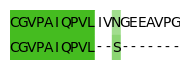

In [36]:
fig, ax = plt.subplots(figsize=(2.0, 0.8))
graphics.plot_alignment_similarity_based(
    ax, alignments[0], matrix=matrix, symbols_per_line=len(alignments[0])
)
fig.tight_layout()


## What if we need them to be identical shapes?

Use `PinderSystem.create_masked_bound_unbound_complexes` to create pairwise-cropped structures with identical shapes.

**Note: this can be destructive as illustrated above.** 

For instance, if the apo or predicted structures are low quality or contain very different atom annotations than the holo structure, it is very possible that the holo structure will be modified significantly and no longer accurately represent the original structure. 

This can be especially pronounced when using both apo and predicted, as any differences between apo and predicted will then propagate to the holo structure equally.

In [39]:
holo_cropped, apo_cropped, pred_cropped = ps.create_masked_bound_unbound_complexes(monomer_types=["apo"], renumber_residues=True)

(
    holo_cropped.atom_array.shape[0], 
    apo_cropped.atom_array.shape[0], 
    pred_cropped.atom_array.shape[0],
)

(756, 756, 3598)

## We specified `monomer_types` apo, but got a tuple of structures that included the predicted complex, why? 

In order to address the concern outlined above, unless explicitly requested via monomer_types (default is `["apo", "predicted"]`), the other monomer type will not be cropped. 

Now we have the apo structure and holo structure with identical shapes. What if we wanted to also include the predicted complex?

In [40]:
holo_cropped, apo_cropped, pred_cropped = ps.create_masked_bound_unbound_complexes(monomer_types=["apo", "predicted"], renumber_residues=True)

(
    holo_cropped.atom_array.shape[0], 
    apo_cropped.atom_array.shape[0], 
    pred_cropped.atom_array.shape[0],
)

(756, 756, 756)

**In this case, including the predicted monomer did not further mutate the holo or apo structures. In other systems, it may.**